# GPU gauge transformation

### Set parametres and eviroment variables

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
# N = 128   
N = 16 
tau_sim = 1     
DTS = 4     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

- - -

In [2]:
import os

# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

# os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
# import curraun.lc_gauge as lc_gauge
import curraun.lc_gauge_zindep as lc_gauge
# Gauge transformation for U_-
lc_gauge.LCDEBUG = True

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using CUDA
Using SU(3)
Using double precision


### We define the simulation routine

In [3]:
# import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 
    output = {}
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    #TODO: for testing only, remove after testing
    mv.set_seed(24)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)

    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize LC gauge transformation
    nplus = maxt//DTS
    lc = lc_gauge.LCGaugeTransf(s, nplus)

    # Plus gauge link
    # xplus=0 is not included
    uplus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, su.GROUP_ELEMENTS)))
    # vlc = su.GROUP_TYPE(np.zeros((nplus, nplus*N, su.GROUP_ELEMENTS)))
    # uplus_temp = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, su.GROUP_ELEMENTS)))

    if lc_gauge.LCDEBUG:
        # xplus=0 in not included
        # also, xplus=maxt is not included
        uminus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-2, N, su.GROUP_ELEMENTS)))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t%DTS == 0:
                # GPU
                xplus = t//DTS
                lc.evolve_lc(xplus)

                if xplus!= 0:
                    uplus_lc[xplus-1] = lc.up_lc.copy()
                    # uplus_temp[xplus-1] = lc.up_temp.copy()

                if lc_gauge.LCDEBUG:
                    if xplus != (maxt//DTS-1):
                        uminus_lc[xplus-1] = lc.um_lc.copy()
                    
                # vlc[xplus] = lc.vlc1.copy()

            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    output["nplus"] = nplus

    output["uplus_lc"] = uplus_lc
    # output["uplus_temp"] = uplus_temp 
    # output["vlc"] = vlc 

    if lc_gauge.LCDEBUG:  
        output["uminus_lc"] = uminus_lc

    return output

In [4]:
output = simulate()

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (112) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (112) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (112) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (112) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWa

Kernel xi: 128 d:  0 did not reach goal. check:  0.000113
Kernel xi: 129 d:  0 did not reach goal. check:  0.133841
Kernel xi: 130 d:  0 did not reach goal. check:  0.000768
Kernel xi: 131 d:  0 did not reach goal. check:  0.009965
Kernel xi: 132 d:  0 did not reach goal. check:  0.975882
Kernel xi: 134 d:  0 did not reach goal. check:  1.717524
Kernel xi: 136 d:  0 did not reach goal. check:  0.000000
Kernel xi: 138 d:  0 did not reach goal. check:  0.724250
Kernel xi: 139 d:  0 did not reach goal. check:  1.301766
Kernel xi: 144 d:  0 did not reach goal. check:  0.000000
Kernel xi: 145 d:  0 did not reach goal. check:  0.000000
Kernel xi: 146 d:  0 did not reach goal. check:  0.000260
Kernel xi: 147 d:  0 did not reach goal. check:  0.000000
Kernel xi: 148 d:  0 did not reach goal. check:  1.301236
Kernel xi: 149 d:  0 did not reach goal. check:  0.983497
Kernel xi: 150 d:  0 did not reach goal. check:  1.973032
Kernel xi: 151 d:  0 did not reach goal. check:  0.001093
Kernel xi: 153

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (112) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (112) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home2/carlos.lamas/cond

In [5]:
uplus_lc = output["uplus_lc"]
nplus = output["nplus"]

#TODO: remove after debug
# uplus_temp = output["uplus_temp"]

if lc_gauge.LCDEBUG:
    uminus_lc = output["uminus_lc"]

In [6]:
uplus_lc.shape

(7, 16, 9)

--- 
Plots

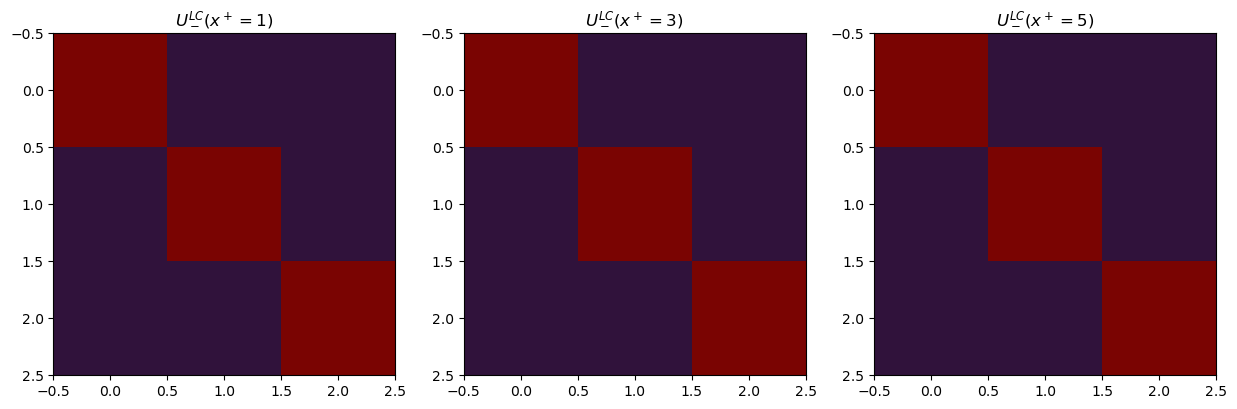

In [7]:
import matplotlib.pyplot as plt 

y = 0

fig_um, axs_um = plt.subplots(1, 3, figsize=(15,30))

for ixplus in range(nplus//3 + 1): 
    xplus = ixplus * 2 + 1
    
    uminuc_lc_color = uminus_lc[xplus, y, :].real.reshape(3,3)
    axs_um[ixplus].imshow(uminuc_lc_color, cmap='turbo', vmin=0, vmax=1) 
    axs_um[ixplus].set_title(r'$U_-^{LC}(x^+ = %i $)' %xplus)
    # plt.colorbar(plot1, ax = axs[t,0])

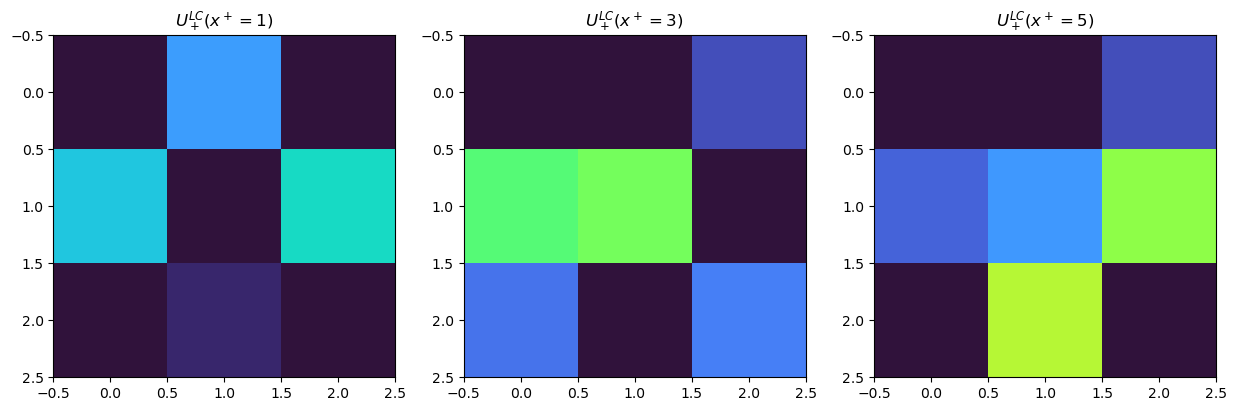

In [8]:
fig_up, axs_up = plt.subplots(1, 3, figsize=(15,30))

for ixplus in range(nplus//3 + 1): 
    xplus = ixplus * 2 + 1
    
    uplus_lc_color = uplus_lc[xplus, y, :].real.reshape(3,3)
    axs_up[ixplus].imshow(uplus_lc_color, cmap='turbo', vmin=0, vmax=1) 
    axs_up[ixplus].set_title(r'$U_+^{LC}(x^+ = %i $)' %xplus)
    # plt.colorbar(plot1, ax = axs[t,0])

- - -
### Comparison with the CPU version

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

# Don't print accuracy check 
import curraun.initial_su3 as initial_su3
initial_su3.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.lc_gauge_zindep as lc_gauge

# Number of colors
Nc = su.NC
# Dimension of algebra 
Dg = su.GROUP_ELEMENTS

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 
    output = {}
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    #TODO: for testing only, remove after testing
    mv.set_seed(24)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)

    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    nplus = maxt//DTS

    # Plus gauge link
    uplus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, Dg)))
    vlc = su.GROUP_TYPE([[su.unit() for y in range(N)] for xplus in range (maxt//DTS)])
    # vlc_out = su.GROUP_TYPE(np.zeros((nplus, nplus, N, su.GROUP_ELEMENTS)))
    uplus_temp = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, Dg)))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t%DTS == 0:
                xplus = t//DTS
                
                u1 = s.u1.copy()
                u0 = s.u0.copy()
                
                ux_act = u1[:,0,:].reshape(N,N,Dg)
                ux_prev = u0[:,0,:].reshape(N,N,Dg)
   
                # We construct the u_+ links over the x^+ axis in a y transverse lattice
                up_temp_test = su.GROUP_TYPE(np.zeros((N,Dg)))
                
                for ix in range(maxt//DTS):
                    for y in range(N):
                        if ix > (t//DTS): # We construct the gauge operator
                            v_prev = vlc[ix, y]
                            vlc[ix, y] = lc_gauge.gauge_transformation_operator(ux_act[2*ix-t//DTS,y], v_prev) 
                            
                        elif ix == (t//DTS) and ix != 0:
                            up_temp_test[y] = lc_gauge.get_plus_links(ux_prev[t//DTS,y])
                            uplus_temp[t//DTS-1, y] = up_temp_test[y]            

                            uplus_lc[xplus-1, y, :] = lc_gauge.act_on_links(up_temp_test[y], vlc[ix, y], vlc[ix-1, y])

                # vlc_out[xplus] = vlc

            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    output["nplus"] = nplus

    output["uplus_lc"] = uplus_lc
    output["uplus_temp"] = uplus_temp 
    # output["vlc"] = vlc 

    return output

In [5]:
output = simulate()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 32/32 [00:02<00:00, 12.47it/s]


In [6]:
uplus_lc = output["uplus_lc"]
nplus = output["nplus"]

#TODO: remove after debug
# uplus_temp = output["uplus_temp"]

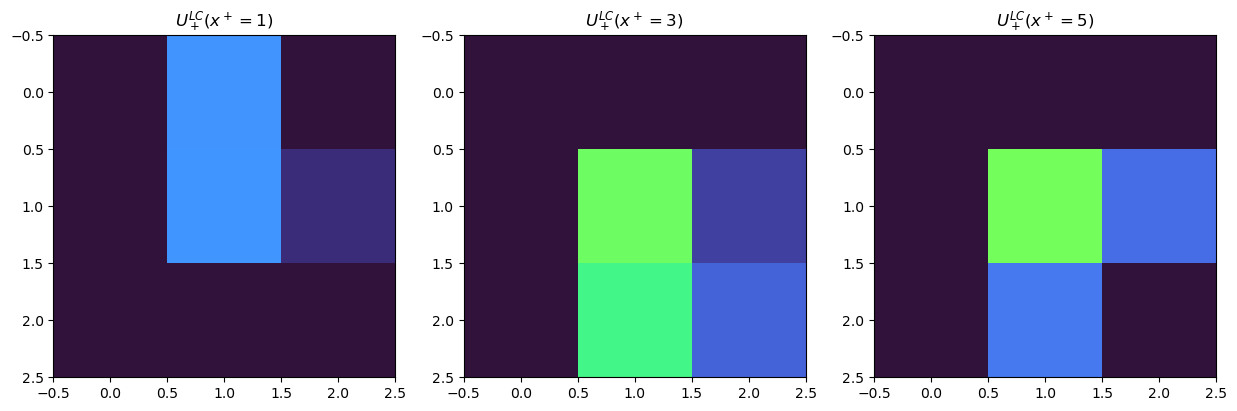

In [7]:
import matplotlib.pyplot as plt 

y = 0
nplus = uplus_lc.shape[0]

fig_up, axs_up = plt.subplots(1, 3, figsize=(15,30))

for ixplus in range(nplus//3 + 1): 
    xplus = ixplus * 2 + 1
    
    uplus_lc_color = uplus_lc[xplus, y, :].real.reshape(3,3)
    axs_up[ixplus].imshow(uplus_lc_color, cmap='turbo', vmin=0, vmax=1) 
    axs_up[ixplus].set_title(r'$U_+^{LC}(x^+ = %i $)' %xplus)
    # plt.colorbar(plot1, ax = axs[t,0])

---
Test lattice functions.

In [ ]:
Ny, Nxplus = N, N//2
# Test arrray
test = np.zeros(Ny*Nxplus)
for i in range(Ny-1):
    for j in range(Nxplus-1):
        test[i*Nxplus+j] = i*Nxplus+j

In [ ]:
def get_index_nm(ix, iy, n):
    return n * ix + iy
def get_point_nxm(x, n, m):
    r1 = x % m 
    r0 = (x - r1) // m
    return r0, r1

In [ ]:
index = get_index_nm(12, 3, Ny)
index

195

In [ ]:
Nxplus

8

In [ ]:
get_point_nxm(index, Nxplus, Ny)

(12, 3)

---
# Debug
Run both the CPU and GPU codes using `numba` in the same loop.

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
# N = 128   
N = 16 
tau_sim = 1     
DTS = 4     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

# TODO: Run more events
nevents = 1

In [2]:
import os

# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="3"

os.environ["MY_NUMBA_TARGET"] = "numba"
# os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

# Don't print accuracy check 
import curraun.initial_su3 as initial_su3
initial_su3.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
# import curraun.lc_gauge as lc_gauge
import curraun.lc_gauge_zindep as lc_gauge
# Gauge transformation for U_-
lc_gauge.LCDEBUG = False

# Number of colors
Nc = su.NC
# Dimension of algebra 
Dg = su.GROUP_ELEMENTS

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import pickle
from tqdm import tqdm

# Simulation routine
def simulate(): 
    output = {}
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    #TODO: for testing only, remove after testing
    mv.set_seed(24)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)

    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize LC gauge transformation
    nplus = maxt//DTS
    lc = lc_gauge.LCGaugeTransf(s, nplus)

    # Plus gauge link
    # xplus=0 is not included
    uplus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, su.GROUP_ELEMENTS)))
    vlc = su.GROUP_TYPE(np.zeros((nplus, nplus*N, su.GROUP_ELEMENTS)))
    uplus_temp = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, su.GROUP_ELEMENTS)))

    # Plus gauge link
    uplus_lc_test = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, Dg)))
    vlc_test = su.GROUP_TYPE([[su.unit() for y in range(N)] for xplus in range (maxt//DTS)])
    vlc_test_out = su.GROUP_TYPE(np.zeros((nplus, nplus, N, su.GROUP_ELEMENTS)))
    uplus_temp_test = su.GROUP_TYPE(np.zeros((maxt//DTS-1, N, Dg)))

    if lc_gauge.LCDEBUG:
        # xplus=0 in not included
        # also, xplus=maxt is not included
        uminus_lc = su.GROUP_TYPE(np.zeros((maxt//DTS-2, N, su.GROUP_ELEMENTS)))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t%DTS == 0:
                # GPU
                xplus = t//DTS
                lc.evolve_lc(xplus)

                if xplus!= 0:
                    uplus_lc[xplus-1] = lc.up_lc.copy()
                    uplus_temp[xplus-1] = lc.up_temp.copy()

                if lc_gauge.LCDEBUG:
                    if xplus != (maxt//DTS-1):
                        uminus_lc[xplus-1] = lc.um_lc.copy()
                    
                vlc[xplus] = lc.vlc1.copy()

                # CPU
                u1 = s.u1.copy()
                u0 = s.u0.copy()
                
                ux_act = u1[:,0,:].reshape(N,N,Dg)
                ux_prev = u0[:,0,:].reshape(N,N,Dg)
   
                # We construct the u_+ links over the x^+ axis in a y transverse lattice
                up_temp_test = su.GROUP_TYPE(np.zeros((N,Dg)))
                
                for ix in range(maxt//DTS):
                    for y in range(N):
                        if ix > (t//DTS): # We construct the gauge operator
                            v_prev = vlc_test[ix, y]
                            vlc_test[ix, y] = lc_gauge.gauge_transformation_operator(ux_act[2*ix-t//DTS,y], v_prev) 
                            
                        elif ix == (t//DTS) and ix != 0:
                            up_temp_test[y] = lc_gauge.get_plus_links(ux_prev[t//DTS,y])
                            uplus_temp_test[t//DTS-1, y] = up_temp_test[y]            

                            uplus_lc_test[xplus-1, y, :] = lc_gauge.act_on_links(up_temp_test[y], vlc_test[ix, y], vlc_test[ix-1, y])

                vlc_test_out[xplus] = vlc_test

            pbar.update(1)

    if use_cuda:
        cuda.current_context().deallocations.clear()

    output["nplus"] = nplus

    output["uplus_lc"] = uplus_lc
    output["uplus_temp"] = uplus_temp 
    output["vlc"] = vlc 

    output["uplus_lc_test"] = uplus_lc_test
    output["uplus_temp_test"] = uplus_temp_test
    output["vlc_test"] = vlc_test_out

    if lc_gauge.LCDEBUG:  
        output["uminus_lc"] = uminus_lc

    return output

In [5]:
output = simulate()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 32/32 [00:04<00:00,  6.47it/s]


In [6]:
nplus = output["nplus"]

uplus_lc = output["uplus_lc"]
uplus_temp = output["uplus_temp"]
vlc = output["vlc"]

uplus_lc_test = output["uplus_lc_test"]
uplus_temp_test = output["uplus_temp_test"]
vlc_test = output["vlc_test"]

if lc_gauge.LCDEBUG:
    uminus_lc = output["uminus_lc"]

In [7]:
uplus_temp == uplus_temp_test

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [8]:
uplus_lc == uplus_lc_test

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [9]:
uplus_lc[0, 1, :] - uplus_lc_test[0, 1, :]

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j])

In [10]:
(uplus_lc-uplus_lc_test).all()

False

In [11]:
vlc_r = vlc.reshape(nplus, nplus, N, Dg)
vlc_r == vlc_test

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  T

In [12]:
zero = [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]

for t in range(vlc_test.shape[0]):
    for x in range(vlc_test.shape[1]):
        for y in range(vlc_test.shape[2]):
            if x > t:
                if (vlc_r[t, x, y, :]-vlc_test[t, x, y, :]).all():
                    print(x, y)
                    print(vlc_r[t, x, y, :]-vlc_test[t, x, y, :])